## Tomato Disease Classification

Import all the requried libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline 

## Loading Dataset from directory

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

### Exploring Dataset & Visualizing some of the images from our dataset

In [5]:
len(dataset)

501

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[6 7 9 9 3 0 2 2 2 7 2 7 3 9 7 0 5 0 4 4 5 3 2 4 4 8 1 7 2 3 2 6]


In [12]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.numpy()[0])

[[[203. 199. 200.]
  [202. 198. 199.]
  [211. 207. 208.]
  ...
  [168. 163. 169.]
  [164. 159. 165.]
  [166. 161. 167.]]

 [[207. 203. 204.]
  [209. 205. 206.]
  [218. 214. 215.]
  ...
  [163. 158. 164.]
  [162. 157. 163.]
  [163. 158. 164.]]

 [[202. 198. 199.]
  [207. 203. 204.]
  [217. 213. 214.]
  ...
  [166. 161. 167.]
  [166. 161. 167.]
  [163. 158. 164.]]

 ...

 [[104.  92.  92.]
  [114. 102. 102.]
  [111.  99.  99.]
  ...
  [100.  89.  93.]
  [ 97.  86.  90.]
  [ 92.  81.  85.]]

 [[111.  99.  99.]
  [117. 105. 105.]
  [113. 101. 101.]
  ...
  [103.  92.  96.]
  [111. 100. 104.]
  [115. 104. 108.]]

 [[110.  98.  98.]
  [112. 100. 100.]
  [108.  96.  96.]
  ...
  [119. 108. 112.]
  [133. 122. 126.]
  [133. 122. 126.]]]


In [14]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


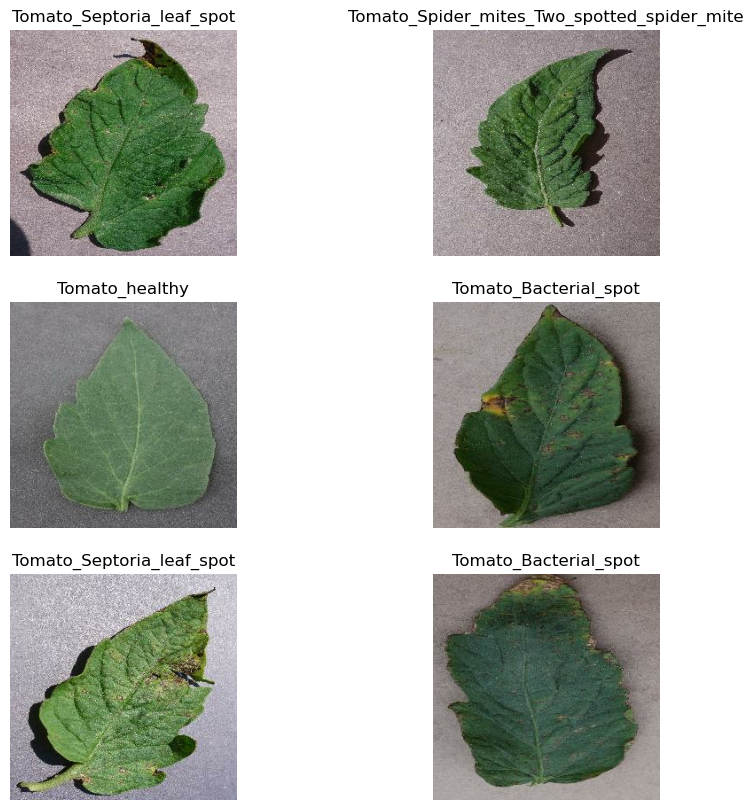

In [18]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Splitting Dataset into Training set, Validation set and Test set

In [19]:
def tain_val_test_split(ds, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, suffle_size=10000):
    ds_size=len(ds)
    
    train_set = ds.take(int(ds_size*train_size))
    val_set = ds.skip(int(ds_size*train_size)).take(int(ds_size*val_size))
    test_set = ds.skip(int(ds_size*train_size)).skip(int(ds_size*val_size))
    
    return train_set, val_set, test_set

In [20]:
train_set, val_set, test_set = tain_val_test_split(dataset)

In [22]:
len(train_set), len(val_set), len(test_set)

(400, 50, 51)

### Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Creating a Layer for Resizing and Normalization

In [25]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(.4)
])

### Building the Model
For hidden layers I used ```relu``` as an activation function

In [28]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

In [30]:
model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

### Compiling the Model
I used ```adam``` as Optimizer, ```SparseCategoricalCrossentropy``` for losses, ```accuracy``` as a metric

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_set,
    batch_size=BATCH_SIZE,
    validation_data=val_set,
    verbose=1,
    epochs=50
)

Epoch 1/50
400/400 [==============================] - 803s 2s/step - loss: 1.6229 - accuracy: 0.4160 - val_loss: 1.7387 - val_accuracy: 0.4231
Epoch 2/50
400/400 [==============================] - 684s 2s/step - loss: 1.0690 - accuracy: 0.6199 - val_loss: 1.5800 - val_accuracy: 0.4881
Epoch 3/50
400/400 [==============================] - 698s 2s/step - loss: 0.7773 - accuracy: 0.7227 - val_loss: 0.9295 - val_accuracy: 0.7069
Epoch 4/50
400/400 [==============================] - 701s 2s/step - loss: 0.5894 - accuracy: 0.7920 - val_loss: 1.0791 - val_accuracy: 0.6837
Epoch 5/50
400/400 [==============================] - 673s 2s/step - loss: 0.4816 - accuracy: 0.8323 - val_loss: 1.2768 - val_accuracy: 0.6506
Epoch 6/50
400/400 [==============================] - 671s 2s/step - loss: 0.3857 - accuracy: 0.8652 - val_loss: 1.3764 - val_accuracy: 0.6712
Epoch 7/50
400/400 [==============================] - 668s 2s/step - loss: 0.3469 - accuracy: 0.8813 - val_loss: 0.7364 - val_accuracy: 0.7850

In [34]:
scores = model.evaluate(test_set)

51/51 [==============================] - 84s 342ms/step - loss: 0.1271 - accuracy: 0.9516


In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

50

In [40]:
history.history['loss'][:5]

[1.6229227781295776,
 1.069017767906189,
 0.7772676944732666,
 0.58935546875,
 0.48164480924606323]

### Plotting the Accuracy and Loss Curves

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

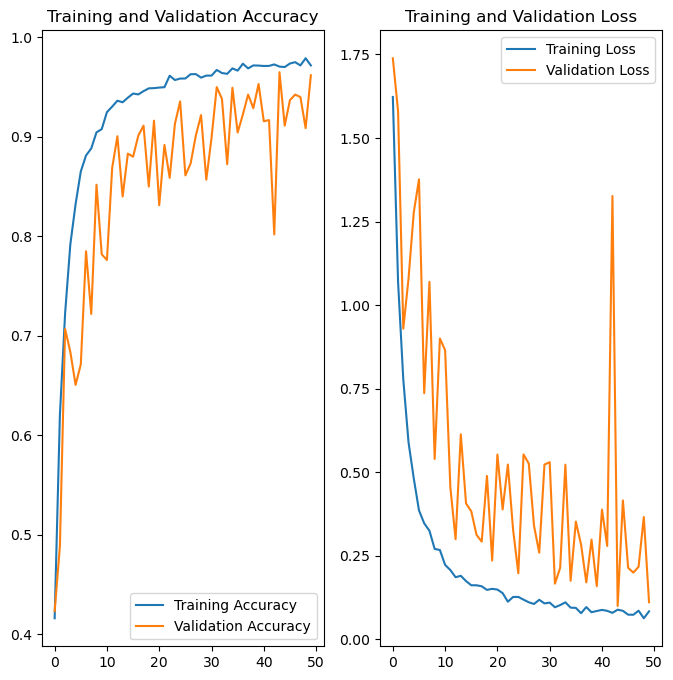

In [42]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato_Septoria_leaf_spot
1/1 [==============================] - 1s 707ms/step
predicted label: Tomato_Septoria_leaf_spot


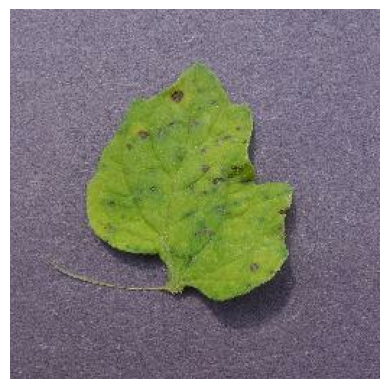

In [43]:
import numpy as np
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


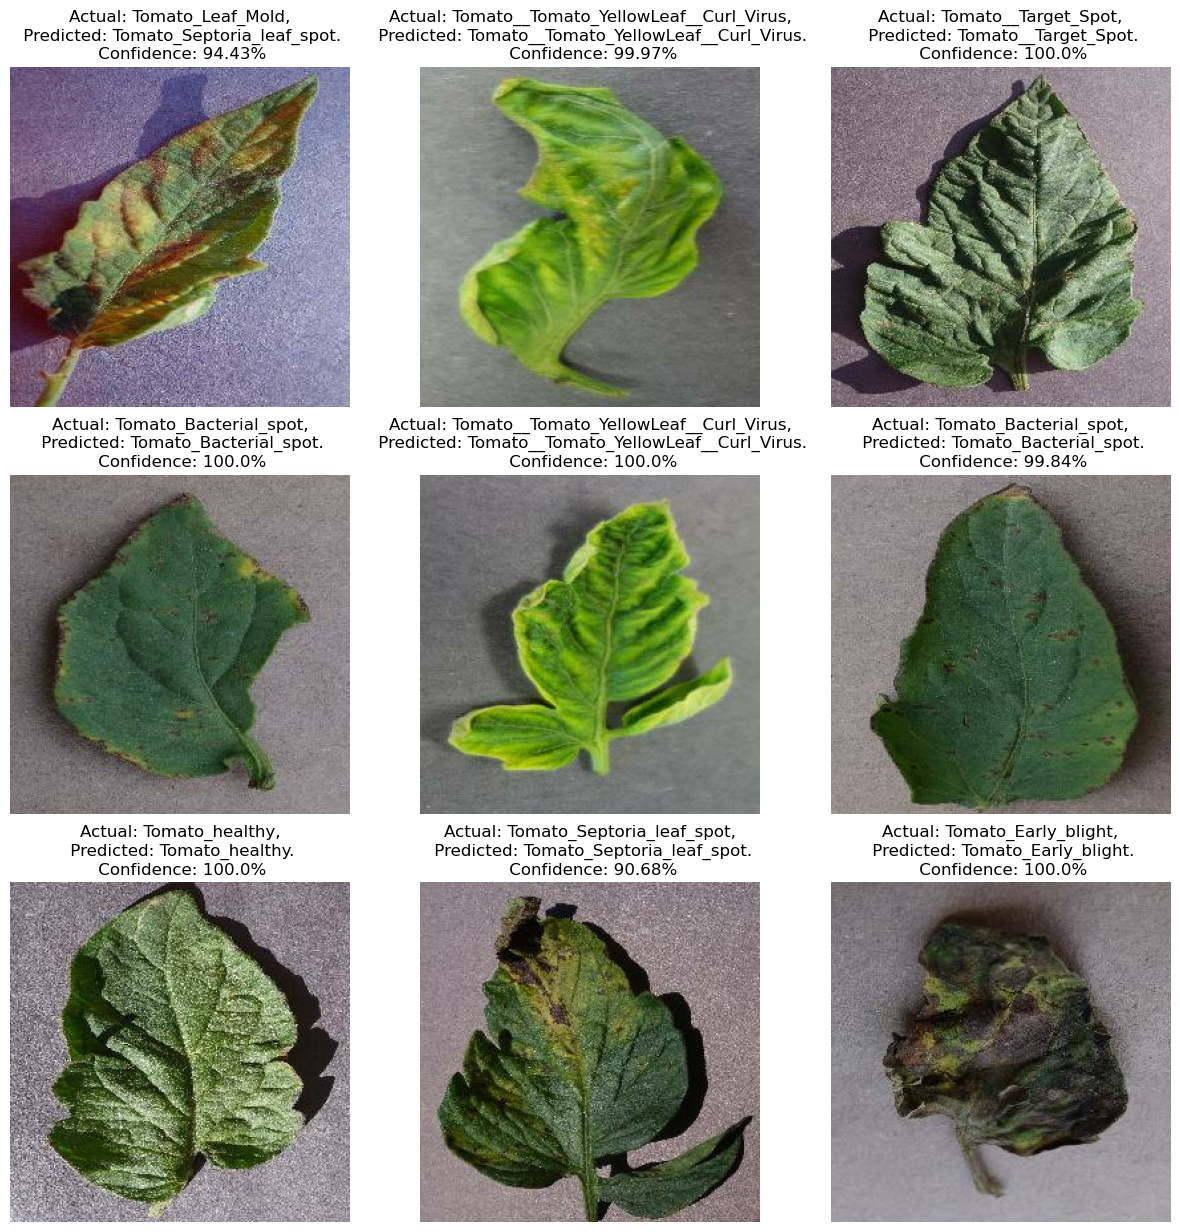

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
Append the model to the list of models as a new version

In [67]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/model_{model_version}")

INFO:tensorflow:Assets written to: ../models/model_1\assets


INFO:tensorflow:Assets written to: ../models/model_1\assets


In [68]:
model.save("../potatoes.h5")

C:\Users\rajas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
